# Inversión sísmica (colored inversion)

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import segyio
import pylops

In [24]:
import warnings
warnings.filterwarnings('ignore')

In [49]:
segyfile = 'datos_sismicos/Kerry3D.segy'

In [9]:
f = segyio.open(segyfile, iline=segyio.tracefield.TraceField.SourceEnergyDirectionExponent, 
                xline=segyio.tracefield.TraceField.CDP)

In [12]:
print(segyio.tools.wrap(f.text[0]))

C01 AREA        : OFFSHORE TARANAKI - OFFSHORE TARANAKI SEISMIC DATABASE
C02 DESCRIPTION : KERRY3D SEISMIC COVERAGE - PHASE MATCHED IN GEOFRAME
C03 ===========================================================================
C04 DATE     :1996       CLASS      :RAW MIGRATION /+90 DEGREE PHASE SHIFT
C05 OPERATOR :WMC        PROCESSING :DIGICON SINGAPORE
C06 ===========================================================================
C07 THE 3D DATA HAS BEEN DATUM AND PHASE SHIFTED. DATA HAS BEEN MERGED WITH
C08 CHECKED NAV AND EXPORTED FROM GEOFRAME 4.2 IN STANDARD SEGY.
C09 INLINES/SP RANGE :510-796 CDP INC       :1        SAMPLE INTERVAL :4000
C10 XLINES/CDP RANGE :58-792  SAMPLES/TRACE :1251     FINAL TIME :5000
C11 LINE INC      :1  TRACES/LINE   :VARIABLE IL/XL X/EAST Y/NORTH
C12 ===========================================================================
C13 THIS DATASET WAS PREPARED AND COMPILED BY THE INSITITUE OF GEOLOGICAL
C14 AND NUCLEAR SCIENCES LIMITED (GNS SCIENCE), 1 FAIRWAY

In [11]:
il, xl, t = f.ilines, f.xlines, f.samples
dt = t[1] - t[0]
d = segyio.cube(f)
nil, nxl, nt = d.shape

In [14]:
vm = np.percentile(d, 99)
print(vm)

2.9088048934936523


In [15]:
extent = (xl[0], xl[-1], t[-1], t[0])

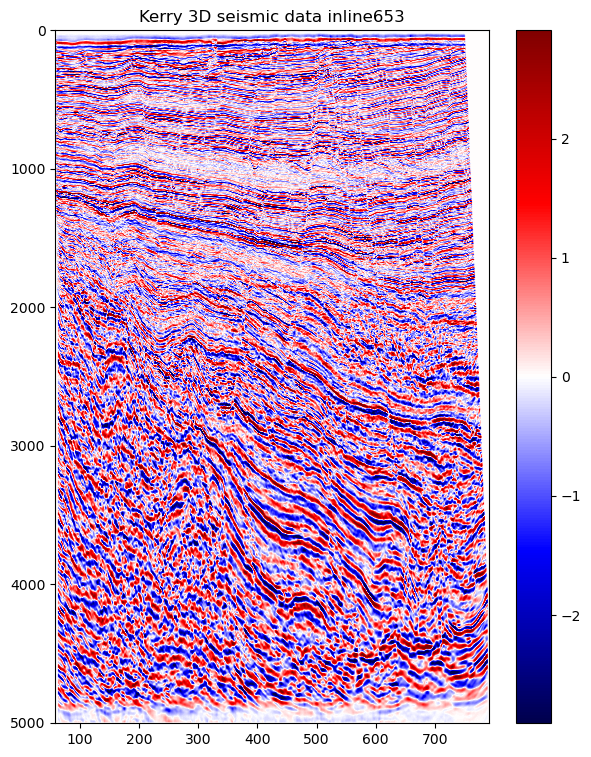

In [20]:
plt.figure(figsize=(7, 9))
plt.imshow(d[nil//2].T, cmap='seismic', vmin=-vm, vmax=vm, extent=extent)
plt.title("Kerry 3D seismic data inline" + str(il[nil//2]))
plt.colorbar()
plt.axis('tight')
plt.show()

## Estimar ondícula de Ricker

In [21]:
nt_wav = 31
nfft = 2**11

# Ejes de tiempo
t_wav = np.arange(nt_wav) * (dt/1000)
t_wav = np.concatenate((np.flipud(-t_wav[1:]), t_wav), axis=0)

# Estimar el espectro en frecuencia
wav_est_fft = np.mean(np.abs(np.fft.fft(d[..., :500], nfft, axis=-1)), axis=(0, 1))
fwest = np.fft.fftfreq(nfft, dt/1000)

# Ondícula de Ricker en tiempo
wav_est = np.real(np.fft.ifft(wav_est_fft)[:nt_wav])
wav_est = np.concatenate((np.flipud(wav_est[1:]), wav_est), axis=0)
wav_est = wav_est / wav_est.max()
wcenter = np.argmax(np.abs(wav_est))

Text(0.5, 1.0, 'Tiempo')

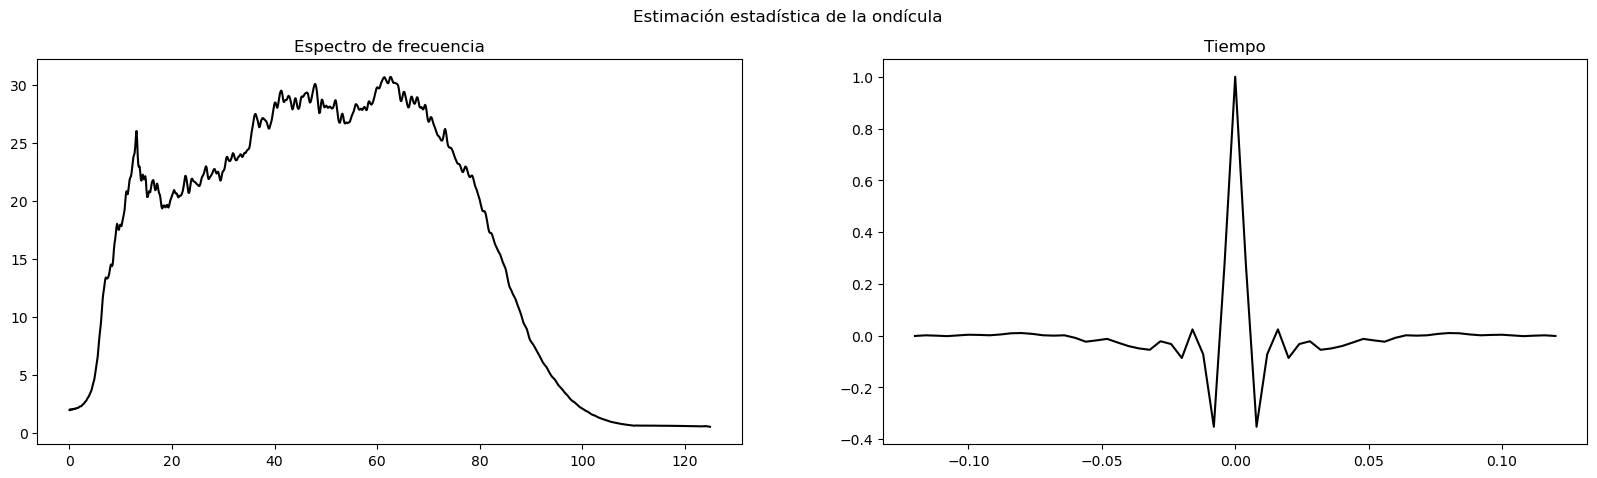

In [22]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))
fig.suptitle('Estimación estadística de la ondícula')
axs[0].plot(fwest[:nfft//2], wav_est_fft[:nfft//2], 'k')
axs[0].set_title('Espectro de frecuencia')
axs[1].plot(t_wav, wav_est, 'k')
axs[1].set_title('Tiempo')

## Realizar inversión

In [23]:
d_small = d[..., :500] # 500 intervalos de muestreo de 4 ms
d_small = np.swapaxes(d_small, -1, 0)

m_relative, r_relative = \
    pylops.avo.poststack.PoststackInversion(d_small, wav_est, m0=np.zeros_like(d_small), 
                                            explicit=True, epsI=1e-4, simultaneous=False)

m_relative_reg, r_relative_reg = \
    pylops.avo.poststack.PoststackInversion(d_small, wav_est, m0=m_relative, 
                                            epsI=1e-4, epsR=1e0, **dict(iter_lim=10, show=2))

d:\Anaconda\envs\segyio\Lib\site-packages\pylops\utils\signalprocessing.py:46: FutureWarning: A new implementation of convmtx is provided in v2.2.0 to match MATLAB's convmtx method as stated in the docstring. The implementation of convmtx provided prior to v2.2.0 was instead not consistent with the documentation. Users are highly encouraged to modify their codes accordingly.
  warnings.warn(


RegularizedInversion
-----------------------------------------------------------------
The Operator Op has 105472500 rows and 105472500 cols
Regs=[<105472500x105472500 Laplacian with dtype=float64>]
epsRs=[1.0]
-----------------------------------------------------------------
 
LSQR            Least-squares solution of  Ax = b
The matrix A has 210945000 rows and 105472500 columns
damp = 0.00000000000000e+00   calc_var =        0
atol = 1.00e-06                 conlim = 1.00e+08
btol = 1.00e-06               iter_lim =       10
 
   Itn      x[0]       r1norm     r2norm   Compatible    LS      Norm A   Cond A
     0  0.00000e+00   2.184e+04  2.184e+04    1.0e+00  1.9e-04
     1  0.00000e+00   1.453e+04  1.453e+04    6.7e-01  6.2e-01   5.6e+00  1.0e+00
     2  0.00000e+00   1.065e+04  1.065e+04    4.9e-01  3.4e-01   8.2e+00  2.3e+00
     3  0.00000e+00   8.750e+03  8.750e+03    4.0e-01  2.3e-01   1.0e+01  3.8e+00
     4  0.00000e+00   7.556e+03  7.556e+03    3.5e-01  1.8e-01   1.1e+01  5

In [25]:
d_small = np.swapaxes(d_small, 0, -1)
m_relative = np.swapaxes(m_relative, 0, -1)
m_relative_reg = np.swapaxes(m_relative_reg, 0, -1)
r_relative = np.swapaxes(r_relative, 0, -1)
r_relative_reg = np.swapaxes(r_relative_reg, 0, -1)

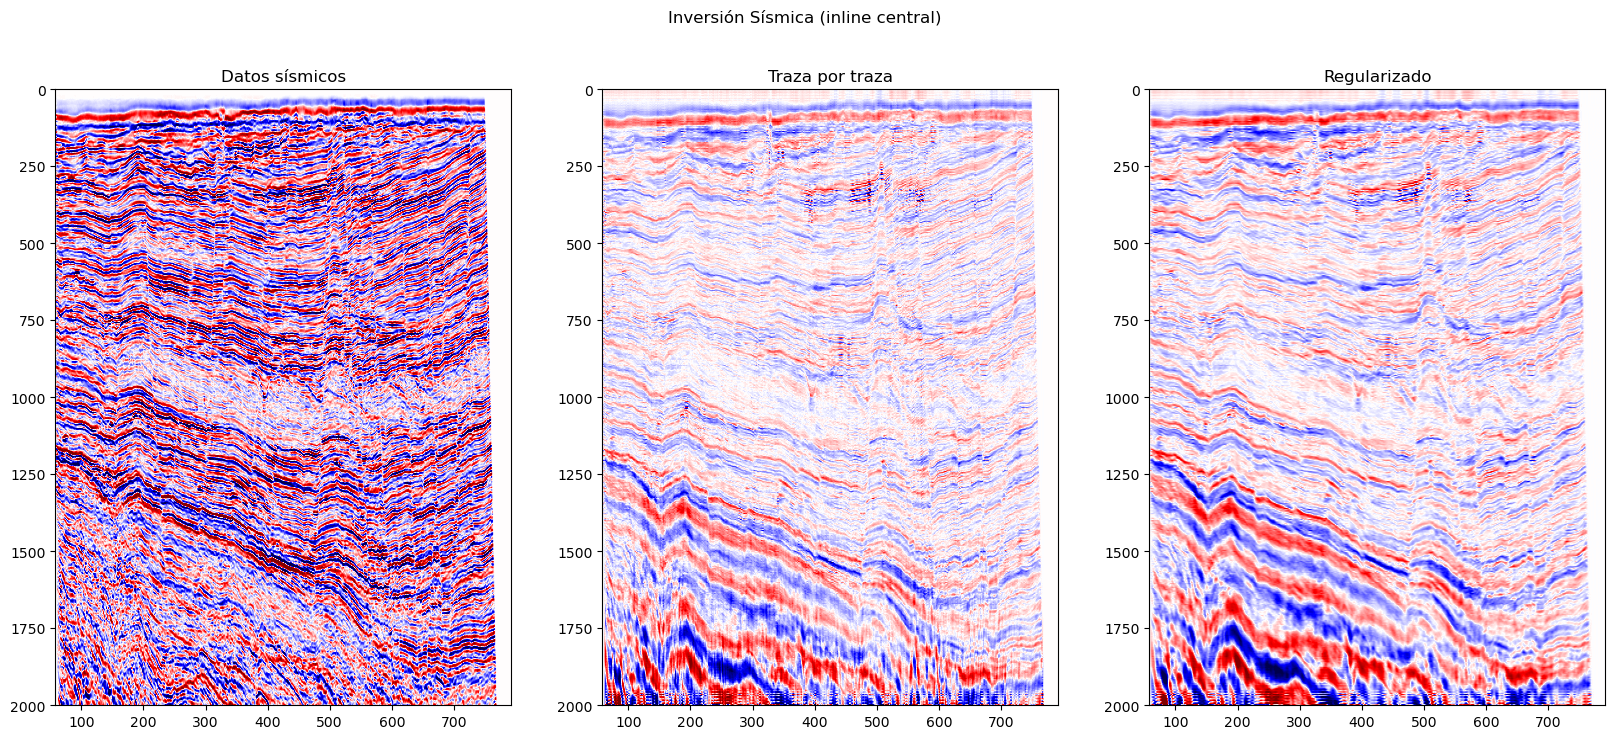

In [32]:
extent_inv = (xl[0], xl[-1], t[500], t[0])

fig, axs = plt.subplots(1, 3, figsize=(20, 8))
fig.suptitle('Inversión Sísmica (inline central)')
axs[0].imshow(d_small[nil//2].T, cmap='seismic', vmin=-vm, vmax=vm, extent=extent_inv)
axs[0].set_title('Datos sísmicos')
axs[0].axis('tight')
axs[1].imshow(m_relative[nil//2].T, cmap='seismic', vmin=-0.2*m_relative.max(), vmax=0.2*m_relative.max(), extent=extent_inv)
axs[1].set_title('Traza por traza')
axs[1].axis('tight')
axs[2].imshow(m_relative_reg[nil//2].T, cmap='seismic', vmin=-0.2*m_relative_reg.max(), vmax=0.2*m_relative_reg.max(), extent=extent_inv)
axs[2].set_title('Regularizado')
axs[2].axis('tight')
plt.show()

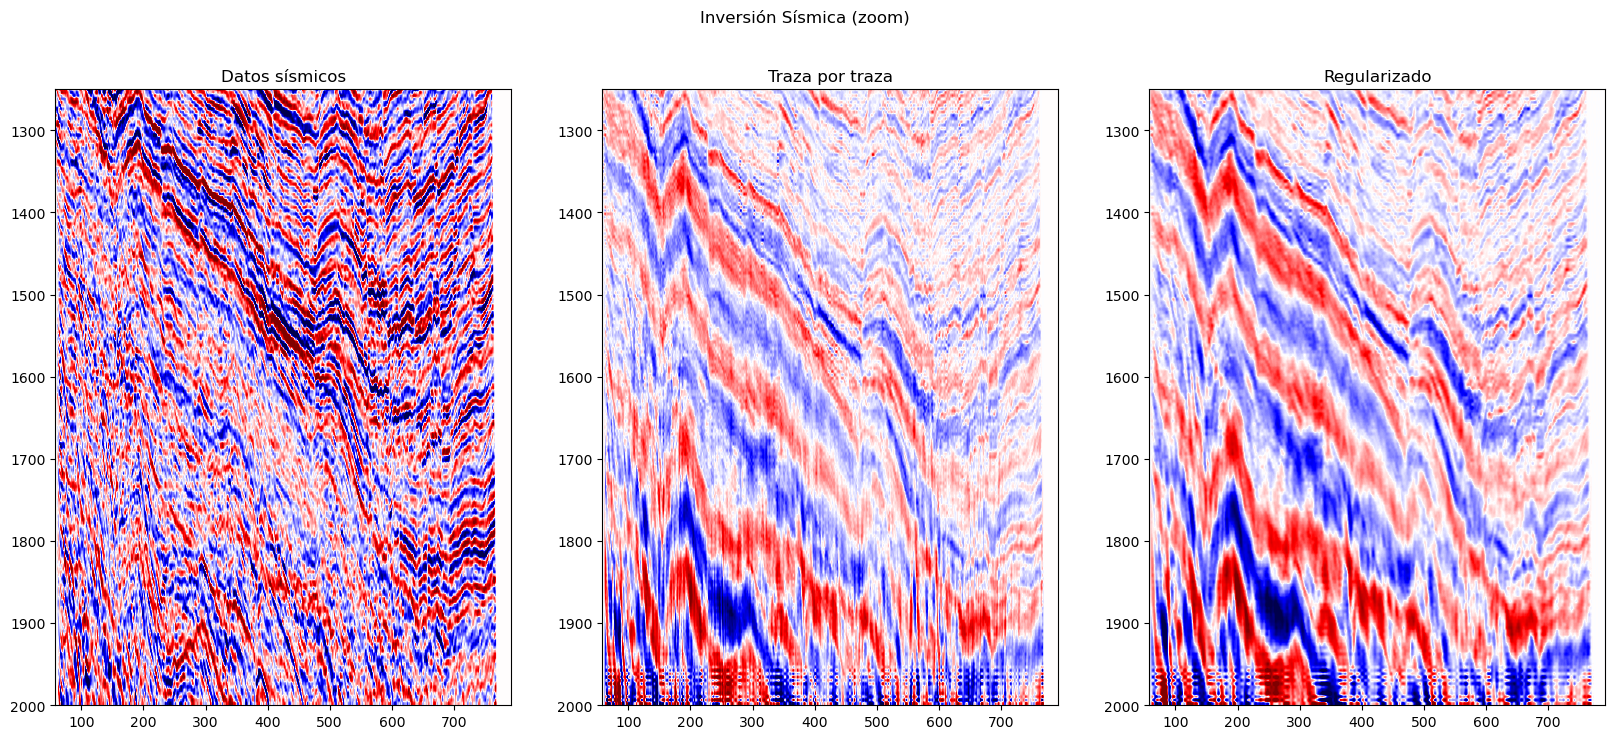

In [33]:
fig, axs = plt.subplots(1, 3, figsize=(20, 8))
fig.suptitle('Inversión Sísmica (zoom)')

axs[0].imshow(d_small[nil//2].T, cmap='seismic', vmin=-vm, vmax=vm, extent=extent_inv)
axs[0].set_title('Datos sísmicos')
axs[0].axis('tight')
axs[0].set_ylim(2000, 1250)

axs[1].imshow(m_relative[nil//2].T, cmap='seismic', vmin=-0.2*m_relative.max(), 
              vmax=0.2*m_relative.max(), extent=extent_inv)
axs[1].set_title('Traza por traza')
axs[1].axis('tight')
axs[1].set_ylim(2000, 1250)

axs[2].imshow(m_relative_reg[nil//2].T, cmap='seismic', vmin=-0.2*m_relative_reg.max(), 
              vmax=0.2*m_relative_reg.max(), extent=extent_inv)
axs[2].set_title('Regularizado')
axs[2].axis('tight')
axs[2].set_ylim(2000, 1250)
plt.show()

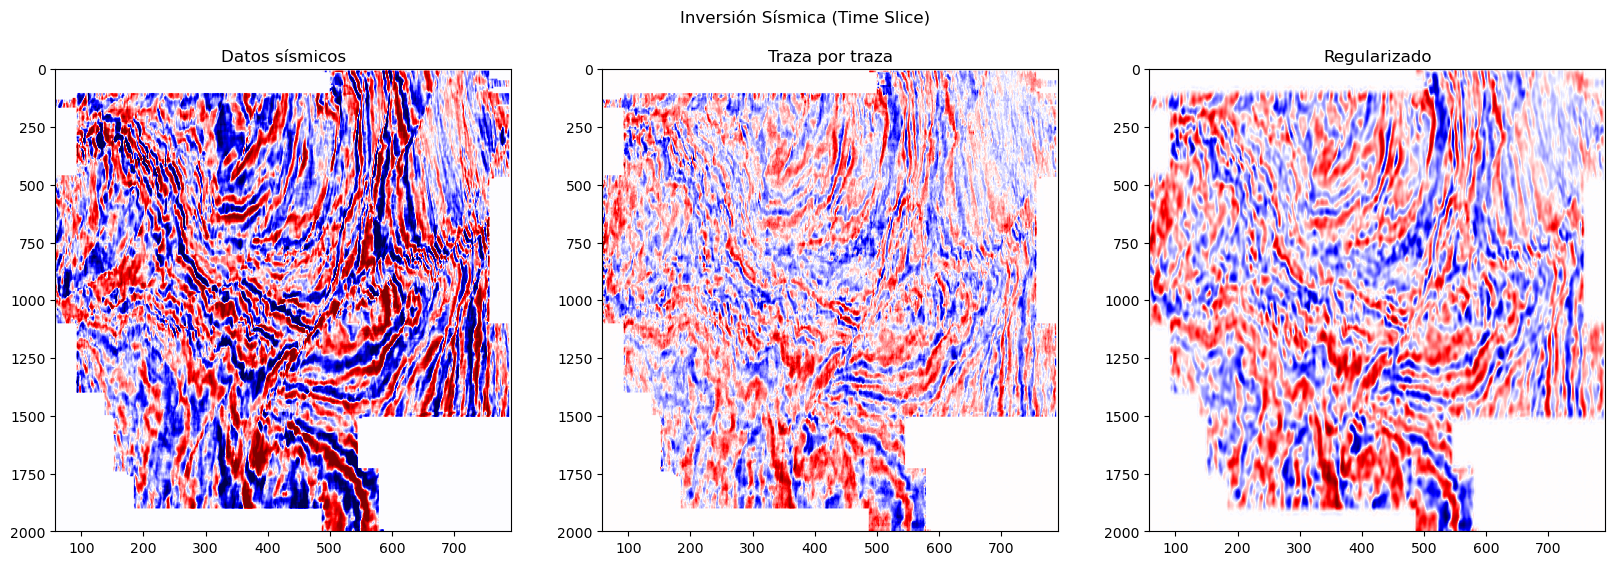

In [37]:
extent_inv_tslice = (xl[0], xl[-1], il[-1], il[0])

fig, axs = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle('Inversión Sísmica (Time Slice)')
axs[0].imshow(d_small[..., 200], cmap='seismic', vmin=-vm, vmax=vm, extent=extent_inv)
axs[0].set_title('Datos sísmicos')
axs[0].axis('tight')
axs[1].imshow(m_relative[..., 200], cmap='seismic', vmin=-0.1*m_relative.max(), vmax=0.1*m_relative.max(), extent=extent_inv)
axs[1].set_title('Traza por traza')
axs[1].axis('tight')
axs[2].imshow(m_relative_reg[..., 200], cmap='seismic', vmin=-0.1*m_relative_reg.max(), vmax=0.1*m_relative_reg.max(), extent=extent_inv)
axs[2].set_title('Regularizado')
axs[2].axis('tight')
plt.show()

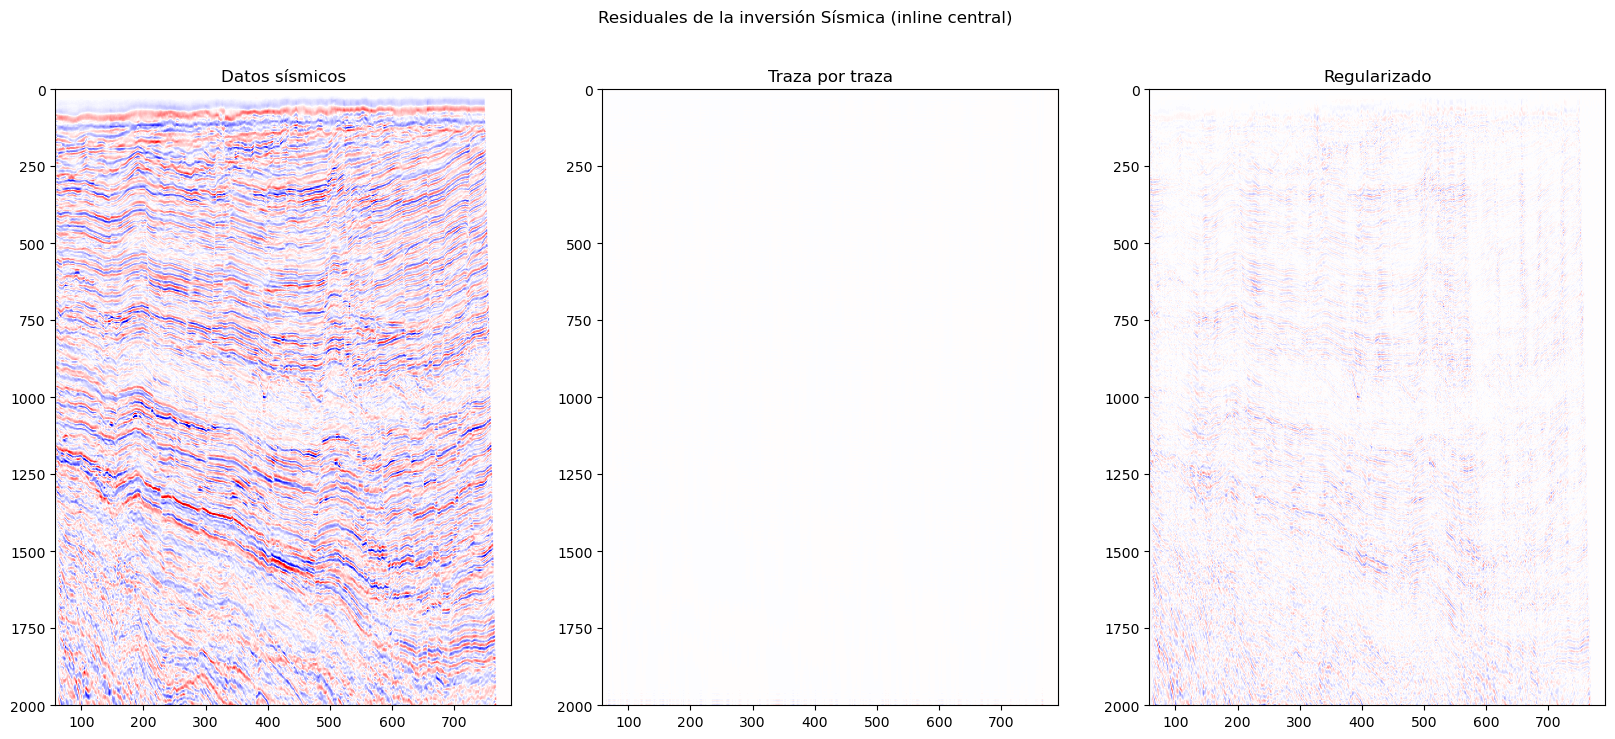

In [41]:
fig, axs = plt.subplots(1, 3, figsize=(20, 8))
fig.suptitle('Residuales de la inversión Sísmica (inline central)')

axs[0].imshow(d_small[nil//2].T, cmap='seismic', vmin=-10, vmax=10, extent=extent_inv)
axs[0].set_title('Datos sísmicos')
axs[0].axis('tight')

axs[1].imshow(r_relative[nil//2].T, cmap='seismic', vmin=-10, vmax=10, extent=extent_inv)
axs[1].set_title('Traza por traza')
axs[1].axis('tight')

axs[2].imshow(r_relative_reg[nil//2].T, cmap='seismic', vmin=-10, vmax=10, extent=extent_inv)
axs[2].set_title('Regularizado')
axs[2].axis('tight')

plt.show()

In [50]:
segyfile_inverted = 'datos_sismicos/invertidos/Kerry3D_inv.segy'

with segyio.open(segyfile, iline=segyio.tracefield.TraceField.SourceEnergyDirectionExponent, 
                 xline=segyio.tracefield.TraceField.CDP) as src:
        spec = segyio.spec()
        spec.sorting = int(src.sorting)
        spec.format = int(src.format)
        spec.samples = t[:500]
        spec.ilines = src.ilines
        spec.xlines = src.xlines

        with segyio.create(segyfile_inverted, spec) as dst:
            # Copy all textual headers, including possible extended
            for i in range(src.ext_headers):
                dst.text[i] = src.text[i]

            # Copy the binary header, then insert the modifications needed for the new time axis
            dst.bin = src.bin
            dst.bin = {segyio.BinField.Samples: 500}
            
            # Copy all trace headers to destination file
            dst.header.iline = src.header.iline
            
            # Modify headers to have IL and XL at more standard bytes
            tr = 0
            for il in spec.ilines:
                for xl in spec.xlines:
                    dst.header[tr] = {
                        segyio.tracefield.TraceField.INLINE_3D : il,
                        segyio.tracefield.TraceField.CROSSLINE_3D : xl,
                        segyio.TraceField.TRACE_SAMPLE_COUNT: 500} 
                    tr +=1

            # Copy data
            for iil, iline in enumerate(dst.ilines):
                dst.iline[iline] = m_relative[iil].astype('float32')